In [2]:
from itertools import combinations
from datetime import datetime, timedelta
from z3 import *
import sys
import os
import re
import math

sys.path.append(os.path.realpath('../../utils'))
from problem import ProblemInstance, parse_problem_file
from solution import SolutionInstance, Circuit
from initial_solution import construct_initial_solution

In [3]:
# Define complex constraints
def at_least_one(bool_vars):
    return Or(bool_vars)

def at_most_one(bool_vars):
    return [Not(And(pair[0], pair[1])) for pair in combinations(bool_vars, 2)]

def exactly_one(solver, bool_vars):
    solver.add(at_most_one(bool_vars))
    solver.add(at_least_one(bool_vars))

In [4]:
inst:ProblemInstance = parse_problem_file('../../instances/ins-5.txt')
print(inst.format_for_dzn())

w = 12;
n = 8;
measures = [|3, 9,
|3, 8,
|3, 7,
|3, 6,
|6, 3,
|3, 5,
|3, 4,
|3, 3,
|];


With these functions we can index the circuits' width and height

In [5]:
W = inst.wg

def get_cw(circ:int, inst):
    return inst.circuits[circ].w

def get_ch(circ:int, inst):
    return inst.circuits[circ].h

Create initial solution

In [6]:
init_inst = construct_initial_solution(inst)
max_h = max([circ.y0 + circ.h for circ in init_inst.circuits])

1. Create all boolean variables for the circuits. We have:
- $px_{c,e}$ indicates that circuit $c$ is placed at a x-axis position less or equal than $e$ (i.e. $x_c \leq e$)
- $py_{c,f}$ indicates that circuit $c$ is placed at a y-axis position less or equal than $f$ (i.e. $y_c \leq f$)

In [7]:
px = [[Bool(f"px_{c}_{e}") for e in range(W)] for c in range(inst.n)]
py = [[Bool(f"py_{c}_{f}") for f in range(max_h)] for c in range(inst.n)]
lr = [[Bool(f"lr_{i}_{j}") for j in range(inst.n) if i != j] for i in range(inst.n)]
ud = [[Bool(f"ud_{i}_{j}") for j in range(inst.n) if i != j] for i in range(inst.n)]

This function is used to index lr and ud

In [8]:
def index_orders(var, c1, c2):
    if c1 == c2:
        raise ValueError
    if c2 > c1:
        return var[c1][c2-1]
    else:
        return var[c1][c2]

2. Create solver instance

In [9]:
s = Solver()

3. Constraints:

- The values for which it makes sense to have True boolean variables $px_{c, e}$ and $py_{c, f}$ depend for each circuit $c$:
    - $e \in \{0 \dots W-w_i\}$
    - $f \in \{0 \dots H-h_i\}$
- For circuit $i$ and for each available position $e$, we have that if $px_{i,e}$ is True, then also $px_{i,e+1}$ must be True, while if $px_{i,e}$ is False, $px_{i,e+1}$ can be anything (i.e. a circuit might start immediately after $e$ or later).
- The same is true on the y-axis.

So we have the following conditions:
$$
\lnot px_{i,e} \lor px_{i,e+1}
$$
$$
\lnot py_{i,f} \lor py_{i,f+1}
$$

In [10]:
for circ in range(inst.n):
    # The circuit should be placed somewhere
    s.add(at_least_one([px[circ][e] for e in range(W-get_cw(circ, inst)+1)]))
    s.add(at_least_one([py[circ][f] for f in range(max_h-get_ch(circ, inst)+1)]))
    # The above conditions ensuring order
    s.add([Or(Not(px[circ][e]), px[circ][e+1]) 
        for e in range(W-get_cw(circ, inst))])
    s.add([Or(Not(py[circ][f]), py[circ][f+1]) 
        for f in range(max_h-get_ch(circ, inst))])

- We can force a circuit to be at (0,0)

In [11]:
s.add(Or([
    And(px[circ][0], py[circ][0]) for circ in range(inst.n)
]))

- Non-overlapping constraints between each rectangle: for each pair of circuits $r_i$, $r_j$, ($i < j$) one must be before the other. 

- Also, the non-overlapping constraint can be decomposed into this formulation: for each pair of rectangles $r_i$ and $r_j$ ($1 \leq i < j \leq n$), we have:
$$
(x_i + w_i \leq x_j) \lor (x_j + w_j \leq x_i) \lor (y_i + h_i \leq y_j) \lor (y_j + h_j \leq y_i)
$$

- With our boolean logic variables we can say that:
    - On the x-axis, if one is before the other (eg. $c_i$ is before $c_j$, so $lr_{i,j} = T$), then for all integers $e$ such that $0 \leq e < W−w_i$, if $c_i$ is placed after $e$, then $c_j$ cannot be placed before $e+w_i$ (i.e. if $c_i$ was placed at $e+1$, it would occupy all cells up to $e+w_i$ and that would be the first available position for the next circuit). We can say something similar when $c_j$ is before $c_i$: then $c_i$ cannot be before position $e+w_j$ if $c_j$ is not before position $0 \leq e < W−w_j$. This can be encoded into the following pair of constraints:
    $$
    \lnot lr_{i,j} \lor px_{i,e} \lor \lnot px_{j,e+w_i}
    $$
    $$
    \lnot lr_{j,i} \lor px_{j,e} \lor \lnot px_{i,e+w_j}
    $$
    - On the y-axis a similar condition occurs.
    $$
    \lnot ud_{i,j} \lor py_{i,f} \lor \lnot py_{j, f+h_i}
    $$
    $$
    \lnot ud_{j,i} \lor py_{j,f} \lor \lnot py_{i, f+h_j}
    $$
- Furthermore, if $i$ is placed before $j$, $c_j$ cannot be placed in the first $w_i$ cells and if $j$ is placed before $i$ $c_i$ cannot be placed in the first $w_j$ cells. A similar constraint is available in the y-axis and can be formalized with the following constraints:
    - $\forall e \in \{0,\dots,w_i\}:  \lnot lr_{i,j} \lor \lnot px_{j,e}$
    - $\forall e \in \{0,\dots,w_j\}:  \lnot lr_{j,i} \lor \lnot px_{i,e}$
    - $\forall f \in \{0,\dots,h_i\}:  \lnot ud_{i,j} \lor \lnot py_{j,f}$
    - $\forall f \in \{0,\dots,h_j\}:  \lnot ud_{j,i} \lor \lnot py_{i,f}$

In [12]:
for ci, cj in combinations(range(inst.n), 2):
    # One must be before the other in some way
    s.add(Or(
        index_orders(lr, ci, cj),
        index_orders(lr, cj, ci),
        index_orders(ud, ci, cj),
        index_orders(ud, cj, ci)
    ))
    # The complex constraint specified above:
    #### HORIZONTAL ####
    # If i is before j, then px[cj] cannot be before ci_w
    for e in range(get_cw(ci, inst)):
        s.add(Or(
            Not(index_orders(lr, ci, cj)),
            Not(px[cj][e])
        ))
    # Then, we pose the full constraint
    for e in range(W-get_cw(ci, inst)):
        s.add(Or(
            Not(index_orders(lr, ci, cj)), 
            px[ci][e],
            Not(px[cj][e+get_cw(ci, inst)])
        ))
    # If j is before i, then px[ci] cannot be before cj_w
    for e in range(get_cw(cj, inst)):
        s.add(Or(
            Not(index_orders(lr, cj, ci)),
            Not(px[ci][e])
        ))
    # Then, we have the full constraint
    for e in range(W-get_cw(cj, inst)):
        s.add(Or(
            Not(index_orders(lr, cj, ci)), 
            px[cj][e],
            Not(px[ci][e+get_cw(cj, inst)])
        ))
    #### VERTICAL ####
    # If i is below j, then py[cj] cannot be before ci_h
    for f in range(get_ch(ci, inst)):
        s.add(Or(
            Not(index_orders(ud, ci, cj)),
            Not(py[cj][f])
        ))
    # Then, we have the full constraint
    for f in range(max_h-get_ch(ci, inst)):
        s.add(Or(
            Not(index_orders(ud, ci, cj)), 
            py[ci][f],
            Not(py[cj][f+get_ch(ci, inst)])
        ))
    # If j is above i, then py[ci] cannot be before cj_h
    for f in range(get_ch(cj, inst)):
        s.add(Or(
            Not(index_orders(ud, cj, ci)),
            Not(py[ci][f])
        ))
    # Then, we have the full constraint
    for f in range(max_h-get_ch(cj, inst)):
        s.add(Or(
            Not(index_orders(ud, cj, ci)), 
            py[cj][f],
            Not(py[ci][f+get_ch(cj, inst)])
        ))

In [13]:
if s.check() == sat:
    m = s.model()
    true_vars = [var for var in s.model() if is_true(m[var])]
    print(true_vars)
else:
    print("Failed to solve")

[py_3_4, py_3_3, ud_3_4, px_1_8, py_4_14, px_0_9, lr_5_6, py_0_5, px_2_2, px_4_4, py_7_11, px_2_7, px_5_8, px_3_3, lr_4_0, px_2_3, px_5_4, px_4_2, ud_2_4, lr_5_7, px_2_5, lr_3_0, py_0_1, px_5_5, px_6_7, ud_0_7, px_2_0, py_0_4, lr_2_1, py_2_2, py_0_3, px_4_1, py_2_6, py_1_5, py_1_4, py_3_2, ud_0_5, py_7_13, py_0_8, px_1_6, px_1_7, px_6_6, px_7_9, py_2_3, py_4_9, py_3_11, ud_1_6, py_3_10, lr_4_6, lr_5_1, py_3_7, px_5_9, px_3_7, py_5_12, px_1_9, py_3_8, py_2_5, lr_2_6, px_2_9, py_4_10, py_3_5, py_1_9, px_2_4, py_3_9, ud_0_6, lr_2_0, py_4_7, px_5_3, py_2_1, px_4_6, lr_4_1, py_4_11, lr_3_7, py_4_12, py_6_12, py_0_7, lr_4_7, py_2_7, px_5_1, py_6_13, px_3_8, py_7_10, py_2_4, py_1_3, px_5_7, lr_5_3, px_4_3, lr_1_7, py_1_6, py_3_1, px_2_6, px_2_8, py_2_10, py_1_8, px_5_6, py_2_0, px_6_8, py_5_14, px_4_5, ud_2_5, py_2_8, px_5_2, py_2_9, px_3_4, lr_3_1, lr_6_7, px_6_9, px_3_6, ud_4_5, px_2_1, py_6_11, px_4_0, py_4_8, lr_3_6, py_1_7, py_3_6, py_0_6, lr_2_3, lr_2_7, py_7_14, px_3_5, py_4_13, py_0_2

[9, 6, 0, 3, 0, 0, 6, 9] [1, 3, 0, 1, 7, 12, 11, 10]
Solution h: 17
Adding 3x9 circuit at (9, 1)
Adding 3x8 circuit at (6, 3)
Adding 3x7 circuit at (0, 0)
Adding 3x6 circuit at (3, 1)
Adding 6x3 circuit at (0, 7)
Adding 3x5 circuit at (0, 12)
Adding 3x4 circuit at (6, 11)
Adding 3x3 circuit at (9, 10)


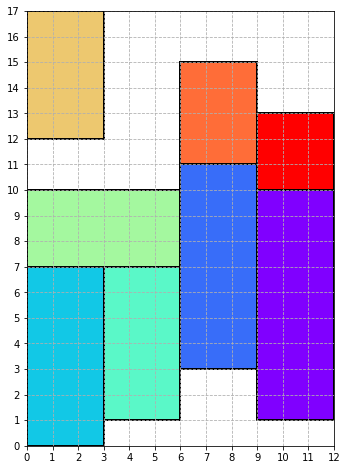

In [14]:
assignments_x = []
assignments_y = []
for circ in range(inst.n):
    assignments_x.append(min([int(str(var).split('_')[-1])
        for var in true_vars 
        if re.match(f'px_{circ}', str(var))]
    ))
    assignments_y.append(min([int(str(var).split('_')[-1])
        for var in true_vars 
        if re.match(f'py_{circ}', str(var))]
    ))
sol_h = max([assignments_y[i] + get_ch(i, inst) for i in range(inst.n)])
print(assignments_x, assignments_y)
print("Solution h: {}".format(sol_h))

solution = SolutionInstance(
    inst.wg, sol_h, inst.n,
    [ Circuit(get_cw(i, inst), get_ch(i, inst), assignments_x[i], assignments_y[i]) 
        for i in range(inst.n) ]
)
solution.draw()

We can have a lower bound to the optimal height of the board ($opt\_h$) dividing the total area of the circuits by $W$: $low\_h = \lfloor \frac{\sum_i h_i w_i}{W} \rfloor$.
If there are no empty spaces in the board this is equal to the optimal height, otherwise it's always true that $opt\_h \geq low\_h$

In [15]:
low_h = math.floor(sum([get_ch(circ, inst)*get_cw(circ, inst) for circ in range(inst.n)]) / W)
low_h

12

To optimally solve a 2SPP with a SAT solver, the paper proposes to solve many 2OPP problems. To do that, it introduces variable $o$ such that $low\_h \leq o \leq max\_h-1$. Then, we can introduce the boolean variable $ph_o$ which is True if all rectangles are packed within a total height $\leq o$. For each rectangle $i$ we can introduce a clause like:
$$
\lnot ph_o \lor py_{i,o-h_i}
$$
meaning that if $ph_o$ is true, then all circuits must be placed at a position inferior to $o-h_i$. We also have a clause to maintain the order encoding:
$$
\lnot ph_o \lor ph_{o+1}
$$

In [16]:
# Note: if max_h = low_h (may happen!) then whatever solution we find is optimal.
ph = {int(o): Bool(f'ph_{o}') for o in range(low_h, max_h+1)}

for o in ph:
    s.add([Or(
        Not(ph[o]),
        py[ci][o-get_ch(ci, inst)]
    ) for ci in range(inst.n)])
    if o < max_h:
        s.add(Or(Not(ph[o]), ph[o+1]))

We can decide satisfiability at a certain height $h$ by adding $ph_h$ as a constraint into the solver.

Trying 10
h=10 is not within the lower/higher bounds for height
Trying 14
[py_3_4, py_3_3, ud_3_4, px_1_8, py_4_14, px_0_7, px_0_9, lr_5_6, lr_0_2, py_0_5, ud_1_7, px_4_4, py_7_11, ud_5_4, ph_17, px_5_8, px_3_3, px_5_4, px_4_2, ud_2_4, lr_5_7, lr_3_0, ud_2_7, py_0_1, px_5_5, py_5_11, lr_0_7, px_6_7, py_6_10, py_0_4, lr_1_6, px_1_5, py_0_3, px_4_1, py_5_10, py_2_6, py_1_5, py_1_4, px_3_1, lr_1_2, py_3_2, lr_6_2, py_7_13, py_0_8, px_1_6, px_1_7, px_6_6, px_7_9, px_3_2, py_5_6, ud_0_4, lr_3_2, py_3_11, lr_4_6, py_3_10, lr_5_1, py_5_8, py_3_7, px_5_9, px_3_7, py_5_12, px_1_9, py_3_8, py_2_5, px_2_9, ph_15, py_3_5, py_1_9, py_5_9, py_3_9, py_3_0, ud_0_6, px_5_3, px_4_6, py_4_11, px_1_3, lr_3_7, py_4_12, py_6_12, py_0_7, lr_4_7, py_5_7, py_2_7, px_5_1, py_6_13, px_3_8, py_2_4, px_0_6, py_1_3, px_5_7, px_4_3, py_1_6, py_3_1, py_2_10, py_1_8, px_3_0, px_5_6, ud_1_4, px_6_8, px_4_5, py_2_8, px_5_2, py_2_9, px_3_4, lr_3_1, lr_6_7, px_6_9, px_3_6, lr_5_2, ph_14, py_6_11, px_4_0, ph_16, lr_3_6, py

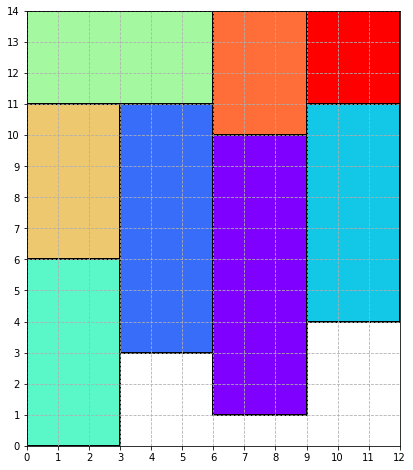

Trying 12
[py_3_4, py_7_6, ph_12, py_3_3, ud_3_4, lr_4_5, px_1_8, py_1_1, py_4_14, px_0_7, px_0_9, lr_0_2, py_0_5, lr_1_5, px_4_4, py_7_11, ph_17, lr_6_4, px_3_3, lr_7_2, px_1_2, ud_2_4, lr_3_0, py_0_1, py_5_11, px_6_7, py_6_9, py_6_10, px_7_3, py_0_4, px_1_5, lr_1_3, px_7_6, py_2_2, py_0_3, py_5_10, px_7_4, py_2_6, lr_7_0, py_1_5, py_1_4, lr_1_2, py_3_2, px_6_4, lr_6_2, py_7_7, py_7_13, py_0_8, px_1_6, px_1_7, px_6_6, lr_6_5, px_7_9, py_2_3, ud_0_4, py_1_0, py_4_9, lr_3_2, py_3_11, ud_1_6, px_7_5, py_3_10, py_5_8, py_3_7, px_5_9, ud_3_6, px_6_1, px_3_7, py_5_12, px_1_0, lr_0_5, px_6_3, px_1_9, py_3_8, px_6_5, py_2_5, px_2_9, ph_15, ud_3_7, py_4_10, py_3_5, py_1_9, py_5_9, py_3_9, py_3_0, ud_7_4, py_2_1, px_4_6, py_4_11, px_1_3, py_4_12, py_6_12, py_0_7, px_6_2, py_5_7, py_2_7, py_6_13, py_1_2, px_3_8, py_7_10, py_7_8, py_2_4, px_0_6, py_1_3, px_4_3, lr_1_7, py_1_6, py_3_1, py_2_10, py_1_8, py_2_0, ud_1_4, px_6_8, px_1_1, px_7_8, px_6_0, ph_13, px_4_5, px_7_7, ud_2_5, py_2_8, py_2_9, p

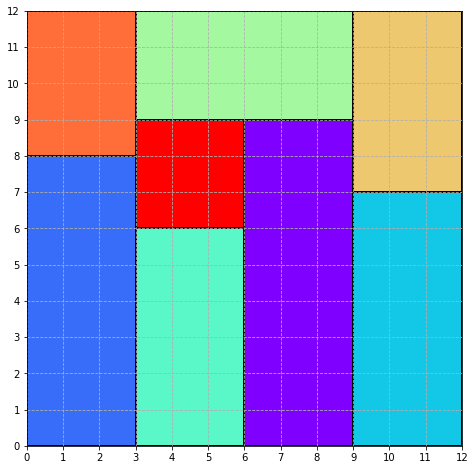

In [17]:
def test_solvability_at_h(s:Solver, inst:ProblemInstance, h:int, verbose=True, draw_sol=True):
    # h is out of the lower/higher bounds for the instance: return unsat
    if h in ph:
        s.push() # Push the solver state
        s.add(ph[h]) # Add h as maximum height and check if it can be solved

        # Calculate time for solving
        start_time = datetime.now()
        # Solve the problem!
        solver_status = s.check()
        end_time = datetime.now()
        duration = end_time - start_time
        duration = duration.seconds + duration.microseconds*1e-6

        if solver_status == sat:
            m = s.model()
            true_vars = [var for var in s.model() if is_true(m[var])]
            if verbose:
                print(true_vars)
            assignments_x = []
            assignments_y = []
            for circ in range(inst.n):
                assignments_x.append(min([int(str(var).split('_')[-1])
                    for var in true_vars 
                    if re.match(f'px_{circ}', str(var))]
                ))
                assignments_y.append(min([int(str(var).split('_')[-1])
                    for var in true_vars 
                    if re.match(f'py_{circ}', str(var))]
                ))
            sol_h = max([assignments_y[i] + get_ch(i, inst) for i in range(inst.n)])
            if verbose:
                print(assignments_x, assignments_y)
                print("Solution h: {}".format(sol_h))

            solution = SolutionInstance(
                inst.wg, sol_h, inst.n,
                [ Circuit(get_cw(i, inst), get_ch(i, inst), assignments_x[i], assignments_y[i]) 
                    for i in range(inst.n) ]
            )
            if draw_sol:
                solution.draw()
        else:
            if verbose:
                print("Failed to solve")
            solution = None

        s.pop() # Restore previous solver condition

    else:
        if verbose:
            print(f"h={h} is not within the lower/higher bounds for height")
        solver_status = unsat
        solution = None
        duration = None
    
    return solver_status, solution, duration

print("Trying 10")
test_solvability_at_h(s, inst, 10)
print("====================")
print("Trying 14")
test_solvability_at_h(s, inst, 14)
print("====================")
print("Trying 12")
test_solvability_at_h(s, inst, 12)
print("====================")

To find the optimal height we can use the **bisection method**:

```
obtain max_h and low_h
push ph[low_h] to constraints       // We try to use the lower bound first because most of our instances have indeed the lower bound as optimal height
solution = solve()
pop solver state

if  solution == SAT then
    return solution

else if solution == UNSAT then
    loop until max_h == low_h
        push ph[low_h+(max_h-low_h)//2] to constraints
        solution = solve()
        pop solver state
        if solution == SAT then
            max_h = low_h+(max_h-low_h)//2
        else if solution == UNSAT then
            lower_bound = low_h+(max_h-low_h)//2

    push ph[low_h] to constraints   // Here we have max_h == low_h
    solution = solve()
    if  solution == SAT then
        return solution
    else
        declare unsolvable
```